In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import copy
import warnings
warnings.filterwarnings('ignore')
import cv2
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img, img_to_array
import matplotlib
import matplotlib.pylab as plt
import numpy as np
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount= False)

Mounted at /content/gdrive


In [ ]:
train_path = "/content/drive/MyDrive/alzheimer_kaggle/AlzheimerDataset/train"
test_path = "/content/drive/MyDrive/alzheimer_kaggle/AlzheimerDataset/test"

In [ ]:
W = 224
H = 224
#168

label_to_class = {
    'MildDemented': 0,
    'ModerateDemented': 1,
    'NonDemented': 2,
    'VeryMildDemented':3
    
}
class_to_label = {v: k for k, v in label_to_class.items()}
n_classes = len(label_to_class)

def get_images(dir_name="/content/gdrive/MyDrive/alzheimer_kaggle/AlzheimerDataset", label_to_class=label_to_class):
    """read images / labels from directory"""
    
    Images = []
    Classes = []
    
    for j in ['/train','/test']:
        for label_name in os.listdir(dir_name+str(j)):
            cls = label_to_class[label_name]

            for img_name in os.listdir('/'.join([dir_name+str(j), label_name])):
                img = load_img('/'.join([dir_name+str(j), label_name, img_name]), target_size=(W, H))
                img = img_to_array(img)

                Images.append(img)
                Classes.append(cls)
            
    Images = np.array(Images, dtype=np.float32)
    Classes = np.array(Classes, dtype=np.float32)
    Images, Classes = shuffle(Images, Classes, random_state=0)
    
    return Images, Classes
    

In [ ]:
## get images / labels
Images, Classes = get_images()

Images.shape, Classes.shape

((6395, 224, 224, 3), (6395,))

In [ ]:
## split train / test

indices_train, indices_test = train_test_split(list(range(Images.shape[0])), train_size=0.8, test_size=0.2, shuffle=False)

x_train = Images[indices_train]
y_train = Classes[indices_train]
x_test = Images[indices_test]
y_test = Classes[indices_test]

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((5116, 224, 224, 3), (5116,), (1279, 224, 224, 3), (1279,))

In [ ]:
from keras.utils import np_utils
## to one-hot

y_train = keras.utils.np_utils.to_categorical(y_train, n_classes)
y_test = keras.utils.np_utils.to_categorical(y_test, n_classes)

y_train.shape, y_test.shape

((5116, 4), (1279, 4))

In [ ]:
## to image data generator
from keras.applications.resnet import ResNet50,preprocess_input

datagen_train = ImageDataGenerator(
    preprocessing_function=preprocess_input, # image preprocessing function
    rotation_range=30,                       # randomly rotate images in the range
    width_shift_range=0.1,                   # randomly shift images horizontally
    height_shift_range=0.1,                  # randomly shift images vertically
    horizontal_flip=True,                    # randomly flip images horizontally
    vertical_flip=False,                     # randomly flip images vertically
)
datagen_test = ImageDataGenerator(
    preprocessing_function=preprocess_input, # image preprocessing function
)

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm

from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
np.random.seed(1000)

# AlexNet model
class AlexNet(Sequential):
    def __init__(self, input_shape, num_classes):
        super().__init__()

        self.add(Conv2D(96, kernel_size=(11,11), strides= 4,
                        padding= 'valid', activation= 'relu',
                        input_shape= input_shape,
                        kernel_initializer= 'he_normal'))
        self.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                              padding= 'valid', data_format= None))

        self.add(Conv2D(256, kernel_size=(5,5), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))
        self.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                              padding= 'valid', data_format= None)) 

        self.add(Conv2D(384, kernel_size=(3,3), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))

        self.add(Conv2D(384, kernel_size=(3,3), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))

        self.add(Conv2D(256, kernel_size=(3,3), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))

        self.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                              padding= 'valid', data_format= None))

        self.add(Flatten())
        self.add(Dense(4096, activation= 'relu'))
        self.add(Dense(4096, activation= 'relu'))
        self.add(Dense(1000, activation= 'relu'))
        self.add(Dense(num_classes, activation= 'softmax'))

        self.compile(optimizer= tf.keras.optimizers.Adam(0.001),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

In [ ]:
num_classes = y_train.shape[1]
model = AlexNet((W,H,3), num_classes)
model.summary()

Model: "alex_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 54, 54, 96)        34944     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 26, 26, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 256)       614656    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 256)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 384)       885120    
                                                                 
 conv2d_3 (Conv2D)           (None, 12, 12, 384)       132

In [ ]:
#Defining the parameters
batch_size= 32
epochs=250

In [ ]:
def process_image(image):
    image=tf.image.per_image_standardization(image)
    image=tf.image.resize(image,(H,W))
    
    return image

In [ ]:
## to image data generator
#dir_train='../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train'
#dir_test='../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test'

datagen_train = ImageDataGenerator(
    preprocessing_function=process_image, # image preprocessing function
    rotation_range=30,                       # randomly rotate images in the range
    zoom_range=0.1,                          # Randomly zoom image
    width_shift_range=0.1,                   # randomly shift images horizontally
    height_shift_range=0.1,                  # randomly shift images vertically
    horizontal_flip=True,                    # randomly flip images horizontally
    vertical_flip=False,                     # randomly flip images vertically
)


datagen_train.fit(x_train)

train_generator = datagen_train.flow(x_train,y_train,batch_size=batch_size)


datagen_test = ImageDataGenerator(
    preprocessing_function=process_image, # image preprocessing function
)

datagen_test.fit(x_test)

test_generator = datagen_test.flow(x_test,y_test,batch_size=batch_size)

#train_num = train_generator.samples
#test_num = test_generator.samples

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
#checkpoint_filepath = '{epoch:02d}-{val_loss:.7f}.hdf5'
checkpoint_filepath = '{epoch:02d}.h5'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1,
    save_best_only=True)

earlystop = EarlyStopping(monitor = 'val_accuracy', 
                          min_delta = 0, 
                          patience = 30,
                          verbose = 1,
                          mode='auto')

reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy',
                              factor = 0.2,
                              patience = 30,
                              verbose = 1,
                              min_delta = 0.0001)
# we put our call backs into a callback list
callbacks = [earlystop, model_checkpoint_callback, reduce_lr]

In [ ]:
import tensorflow as tf
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc')
]

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=METRICS)

epochs = 100
history=model.fit(datagen_train.flow(x_train,y_train, batch_size=64,shuffle=True), epochs=epochs,validation_data=datagen_test.flow(x_test,y_test, batch_size=16,shuffle=True), callbacks=callbacks )

Epoch 1/100
80/80 [==============================] - ETA: 0s - loss: 5.4239 - accuracy: 0.7533 - precision: 0.5139 - recall: 0.2428 - auc: 0.7596
Epoch 1: val_accuracy improved from -inf to 0.78127, saving model to 01.h5
80/80 [==============================] - 85s 916ms/step - loss: 5.4239 - accuracy: 0.7533 - precision: 0.5139 - recall: 0.2428 - auc: 0.7596 - val_loss: 0.9787 - val_accuracy: 0.7813 - val_precision: 0.5978 - val_recall: 0.3823 - val_auc: 0.8158 - lr: 0.0010
Epoch 2/100
80/80 [==============================] - ETA: 0s - loss: 0.9635 - accuracy: 0.7875 - precision: 0.6692 - recall: 0.2969 - auc: 0.8197
Epoch 2: val_accuracy improved from 0.78127 to 0.79261, saving model to 02.h5
80/80 [==============================] - 71s 894ms/step - loss: 0.9635 - accuracy: 0.7875 - precision: 0.6692 - recall: 0.2969 - auc: 0.8197 - val_loss: 0.9554 - val_accuracy: 0.7926 - val_precision: 0.7309 - val_recall: 0.2697 - val_auc: 0.8282 - lr: 0.0010
Epoch 3/100
80/80 [==================

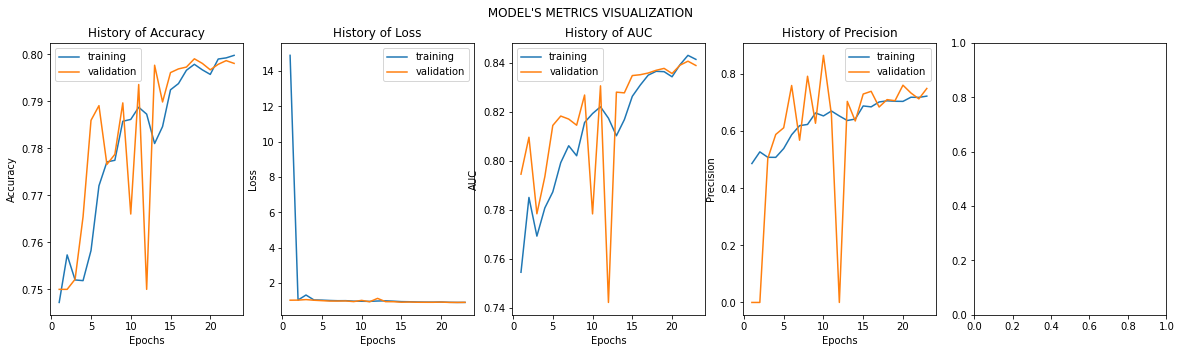

In [ ]:
#%% PLOTTING RESULTS (Train vs Validation FOLDER 1)

def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision):
    
    fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])
    

    plt.show()
    

Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'],
               history.history['auc'],history.history['val_auc'],
               history.history['precision'],history.history['val_precision'])  


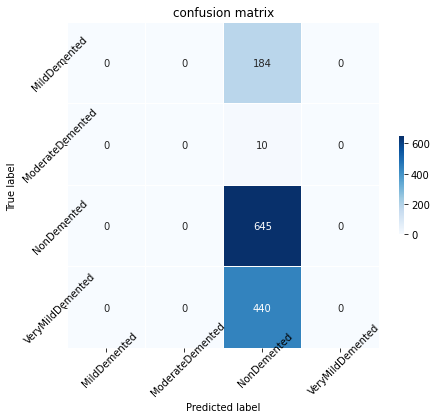

In [ ]:
## plot confusion matrix
y_preds = model.predict(x_test)
y_preds = np.argmax(y_preds, axis=1)
y_trues = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_trues, y_preds)

fig, ax = plt.subplots(figsize=(7, 6))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar_kws={'shrink': .3}, linewidths=.1, ax=ax)

ax.set(
    xticklabels=list(label_to_class.keys()),
    yticklabels=list(label_to_class.keys()),
    title='confusion matrix',
    ylabel='True label',
    xlabel='Predicted label'
)
params = dict(rotation=45, ha='center', rotation_mode='anchor')
plt.setp(ax.get_yticklabels(), **params)
plt.setp(ax.get_xticklabels(), **params)
plt.show()

In [ ]:
print("F1 Score (testing): %.2f%%"% (f1_score(y_trues, y_preds, average='weighted')*100.0))

F1 Score (testing): 33.81%


In [ ]:
print("accuracy (testing): %.2f%%"% (accuracy_score(y_trues, y_preds)*100.0))

accuracy (testing): 50.43%


In [ ]:
report = classification_report(y_trues, y_preds)
print(report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       184
           1       0.00      0.00      0.00        10
           2       0.50      1.00      0.67       645
           3       0.00      0.00      0.00       440

    accuracy                           0.50      1279
   macro avg       0.13      0.25      0.17      1279
weighted avg       0.25      0.50      0.34      1279



In [ ]:
model.save('alexnet.hdf5')